<a href="https://colab.research.google.com/github/jamespaultg/PrivacyPreservingAnalytics/blob/master/Privacy_in_Machine_Learning_Demo_Code_%7C_Jordan_Harrod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the notebook for the Privacy in Machine Learning vider from Jordan Harrod's AI 101 series on YouTube! 

If you haven't already watched the video, you can check it out here: https://www.youtube.com/watch?v=MOcTGM_UteM

This notebook contains two examples of how differential privacy and federated learning work, relying on existing code libraries that simplify their implementations for programmers who are not cryptography experts (like me!). 

# **These examples are adapted from the examples provided by the developers of each library - all credit goes to the original authors. **

To run any of the examples, click on "Open in Playground" on the top left, then hover over the top left corner of any code block and click on the arrow that appears.

Links to the relevant libraries can be found here: 

IBM Differential Privacy - https://github.com/IBM/differential-privacy-library

PySyft - https://github.com/OpenMined/PySyft



In [0]:
# This code block downloads, installs, and imports the relevant libraries. 

!pip install numpy
!pip install scikit-learn
!pip install syft[udacity]
!pip install diffprivlib

import numpy 
import sklearn 
from sklearn import datasets
import syft 
import diffprivlib
import matplotlib.pyplot as plt
import torch 
from torch import nn
from torch import optim

Our first example focuses on differential privacy. Here, we can create a figure that compares the accuracy of our predictions with the level of privacy on our data by changing epsilon. 

This example has been adapted from the example provided in the IBM Differential Privacy Github Repository - see sources at the top for the original version. 

/usr/local/lib/python3.6/dist-packages/diffprivlib/models/naive_bayes.py:93: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/usr/local/lib/python3.6/dist-packages/diffprivlib/models/naive_bayes.py:93: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/usr/local/lib/python3.6/dist-packages/diffprivlib/models/naive_bayes.py:93: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additiona

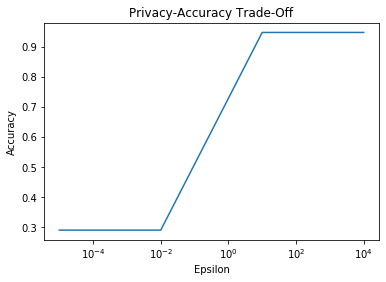

In [0]:
data, labels = datasets.load_iris(return_X_y=True)
data_train, data_test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels)

def sweep(eps=[0.00001, 0.001, 0.01, 10, 1000, 10000]):
  accuracy = [] 
  for i in range(len(eps)):
    model = diffprivlib.models.GaussianNB(epsilon=eps[i])
    model.fit(data_train, labels_train)
    accuracy.append(sklearn.metrics.accuracy_score(labels_test, model.predict(data_test)))
  return accuracy 

eps=[0.00001, 0.001, 0.01, 10, 1000, 10000] # Try changing these values to see how the accuracy plot changes! 

accuracy = sweep(eps)


plt.figure() # notice that the accuracy for each value changes every time you run it with the same values 
plt.semilogx(eps, accuracy) # this is because random noise is... well, random, so the accuracy shifts a bit based on how the data was altered each time! 
plt.title('Privacy-Accuracy Trade-Off')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()



Our second example focuses federated learning, using a library called PySyft. 

This example is adapted from the federated learning tutorial here: https://github.com/OpenMined/PySyft/blob/master/examples/tutorials/Part%2002%20-%20Intro%20to%20Federated%20Learning.ipynb 

Edit 2/29/20: A note on this example (which is also pointed out on the OpenMinded tutorial) - this is meant to show how the learning process works when you're pulling from separate datasets, but this process actually doesn't ensure privacy! You can call model.get() to learn about how to predict well on Alice's data without having seen it, which can help you learn more about the dataset itself, even potentially replicating it perfectly. A way to avoid this is to average Bob and Alice's model updates before sending them to the global model as we talked about in the video! Thanks to u//raj111sam for pointing this out on the r/artificial subreddit. 

In [0]:
hook = syft.TorchHook(torch)

bob = syft.VirtualWorker(hook, id="bob")
alice = syft.VirtualWorker(hook, id="alice")

data = torch.tensor([[0,0],[0,1],[1,0],[1,1.]], requires_grad=True)
target = torch.tensor([[0],[0],[1],[1.]], requires_grad=True)

# get pointers to training data on each worker by
# sending some training data to bob and alice
data_bob = data[0:2]
target_bob = target[0:2]

data_alice = data[2:]
target_alice = target[2:]

# Iniitalize A Toy Model
model = nn.Linear(2,1)

data_bob = data_bob.send(bob)
data_alice = data_alice.send(alice)
target_bob = target_bob.send(bob)
target_alice = target_alice.send(alice)

# organize pointers into a list
datasets = [(data_bob,target_bob),(data_alice,target_alice)]

opt = optim.SGD(params=model.parameters(),lr=0.1)

def train():
    # Training Logic
    opt = optim.SGD(params=model.parameters(),lr=0.1)
    for iter in range(10):
        
        # NEW) iterate through each worker's dataset separately
        for data,target in datasets:
            
            # NEW) send model to correct worker - either Alice or Bob
            model.send(data.location)

            # 1) Reset the optimizer so that we can develop a new model
            opt.zero_grad()

            # 2) Predict on new (unseen) data using the model from the cloud
            pred = model(data)

            # 3) See how well (or not) we did on that prediction
            loss = ((pred - target)**2).sum()

            # 4) Figure out why we performed poorly
            loss.backward()

            # 5) Update the model's weights 
            opt.step()
            
            # NEW) Get the new model, to be tested and improved on a new, separate dataset 
            model.get()

            # 6) print our progress
            print(loss.get()) # NEW) slight edit... need to call .get() on loss\
    
# federated averaging

train()

tensor(0.4024, requires_grad=True)
tensor(1.5361, requires_grad=True)
tensor(0.9169, requires_grad=True)
tensor(0.3524, requires_grad=True)
tensor(0.6367, requires_grad=True)
tensor(0.2119, requires_grad=True)
tensor(0.4217, requires_grad=True)
tensor(0.1414, requires_grad=True)
tensor(0.2818, requires_grad=True)
tensor(0.0966, requires_grad=True)
tensor(0.1906, requires_grad=True)
tensor(0.0672, requires_grad=True)
tensor(0.1304, requires_grad=True)
tensor(0.0475, requires_grad=True)
tensor(0.0902, requires_grad=True)
tensor(0.0340, requires_grad=True)
tensor(0.0630, requires_grad=True)
tensor(0.0246, requires_grad=True)
tensor(0.0445, requires_grad=True)
tensor(0.0180, requires_grad=True)
